In [2]:
# Import packages
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
from shapely import speedups
import numpy as np
import contextily as ctx

In [3]:
# Read input data
fp = r"data/THOR_WWII_DATA_CLEAN.csv"
data = pd.read_csv(fp, sep=",", encoding='latin1', low_memory=False)
#fp = r"data/Germany_1939_wgs84.shp"
#germany39 = gpd.read_file(fp)
fp = r"data/DEU_adm1.shp"
germany2020 = gpd.read_file(fp)

In [4]:
geo = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data["LONGITUDE"], data["LATITUDE"]))

In [5]:
# Check if input GeoDataFrame has crs info
geo.crs

In [6]:
# Assign projection to GeoDataFrame
geo = geo.set_crs(epsg=4326)
geo = geo.to_crs(epsg=32633)

# Reproject germany2020 GeoDataFrame to metric
germany2020 = germany2020.to_crs(epsg=32633)

In [7]:
# Check that both map and geodataframe have same crs
geo.crs == germany2020.crs

True

In [8]:
# Drop unneccessary fields from germany2020
germany2020 = germany2020[["NAME_1", "geometry"]]
# Calculate area of german states
germany2020["area"] = germany2020["geometry"].area/10**6

In [9]:
# Check GeoDataFrame columns
geo.columns

Index(['WWII_ID', 'MASTER_INDEX_NUMBER', 'MSNDATE', 'THEATER', 'NAF',
       'COUNTRY_FLYING_MISSION', 'TGT_COUNTRY_CODE', 'TGT_COUNTRY',
       'TGT_LOCATION', 'TGT_TYPE', 'TGT_ID', 'TGT_INDUSTRY_CODE',
       'TGT_INDUSTRY', 'SOURCE_LATITUDE', 'SOURCE_LONGITUDE', 'LATITUDE',
       'LONGITUDE', 'UNIT_ID', 'MDS', 'AIRCRAFT_NAME', 'MSN_TYPE',
       'TGT_PRIORITY', 'TGT_PRIORITY_EXPLANATION', 'AC_ATTACKING', 'ALTITUDE',
       'ALTITUDE_FEET', 'NUMBER_OF_HE', 'TYPE_OF_HE', 'LBS_HE', 'TONS_OF_HE',
       'NUMBER_OF_IC', 'TYPE_OF_IC', 'LBS_IC', 'TONS_OF_IC', 'NUMBER_OF_FRAG',
       'TYPE_OF_FRAG', 'LBS_FRAG', 'TONS_OF_FRAG', 'TOTAL_LBS', 'TOTAL_TONS',
       'TAKEOFF_BASE', 'TAKEOFF_COUNTRY', 'TAKEOFF_LATITUDE',
       'TAKEOFF_LONGITUDE', 'AC_LOST', 'AC_DAMAGED', 'AC_AIRBORNE',
       'AC_DROPPING', 'TIME_OVER_TARGET', 'SIGHTING_METHOD_CODE',
       'SIGHTING_EXPLANATION', 'BDA', 'CALLSIGN', 'ROUNDS_AMMO',
       'SPARES_RETURN_AC', 'WX_FAIL_AC', 'MECH_FAIL_AC', 'MISC_FAIL_AC',
       

In [10]:
# Select required columns for further analysis
geo = geo[["geometry", "TOTAL_TONS", "MSNDATE"]]

<AxesSubplot:>

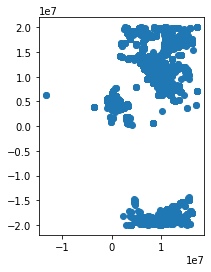

In [11]:
# Visually inspect data (notice outliers)
geo.plot()

In [12]:
# Select points within Germany 1939
ger_bombs = gpd.sjoin(geo, germany2020, op = 'within')

In [13]:
ger_bombs

geometry  TOTAL_TONS    MSNDATE  index_right  \
11      POINT (392821.289 5821161.996)         1.0  8/15/1943            2   
12      POINT (392821.289 5821161.996)         4.0  8/15/1943            2   
651     POINT (392821.289 5821161.996)         1.0  8/17/1943            2   
652     POINT (392821.289 5821161.996)         6.0  8/17/1943            2   
1239    POINT (392821.289 5821161.996)         1.0  8/19/1943            2   
...                                ...         ...        ...          ...   
177674  POINT (317476.732 5689782.432)        28.0  7/28/1944           13   
177675  POINT (317476.732 5689782.432)        30.0  7/28/1944           13   
177676  POINT (317476.732 5689782.432)        30.0  7/28/1944           13   
177677  POINT (317476.732 5689782.432)        30.0  7/28/1944           13   
177806  POINT (412383.757 5656128.432)         3.0  2/15/1945           13   

         NAME_1          area  
11       Berlin    884.865524  
12       Berlin    884.865524  
651      Berlin    884.865524  
652      Berlin    884.865524  
1239     Berlin    884.865524  
...         ...           ...  
177674  Sachsen  18410.690209  
177675  Sachsen  18410.690209  
177676  Sachsen  18410.690209  
177677  Sachsen  18410.690209  
177806  Sachsen  18410.690209  

[55852 rows x 6 columns]

In [14]:
# Select only required columns for further analysis
ger_bombs = ger_bombs[["geometry", "TOTAL_TONS", "NAME_1", "area"]]

In [15]:
# Drop rows containing na
ger_bombs = ger_bombs.dropna()

<AxesSubplot:>

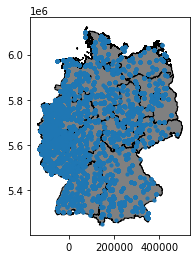

In [16]:
# Visually inspect data
ax = germany2020.plot(facecolor="gray", edgecolor="black")
ger_bombs.plot(ax=ax, markersize=10)

In [17]:
# Aggregate data by state
bombs_by_state = ger_bombs.groupby("NAME_1").agg({"TOTAL_TONS" : "sum"})

# Join 
join = germany2020.merge(bombs_by_state, on="NAME_1")

In [18]:
# Calculate bombs per land area
join["TONS_PER_KM2"] = join["TOTAL_TONS"] / join["area"]

In [19]:
join

NAME_1                                           geometry  \
0        Baden-Württemberg  MULTIPOLYGON (((28189.137 5303887.952, 28230.4...   
1                   Bayern  POLYGON ((155332.447 5611099.265, 155698.436 5...   
2                   Berlin  POLYGON ((376007.307 5806014.243, 375181.687 5...   
3              Brandenburg  POLYGON ((425678.204 5928596.809, 425659.173 5...   
4                   Bremen  MULTIPOLYGON (((66735.460 5917886.615, 67532.9...   
5                  Hamburg  POLYGON ((174889.422 5963456.014, 174910.249 5...   
6                   Hessen  POLYGON ((119379.112 5734401.962, 119761.886 5...   
7   Mecklenburg-Vorpommern  MULTIPOLYGON (((451469.753 5951585.048, 451469...   
8            Niedersachsen  MULTIPOLYGON (((-37838.503 5969389.249, -37842...   
9      Nordrhein-Westfalen  POLYGON ((70522.351 5838336.646, 70890.392 583...   
10         Rheinland-Pfalz  POLYGON ((-5589.522 5668216.199, -4772.321 566...   
11                Saarland  POLYGON ((-74523.759 5529491.292, -73309.040 5...   
12          Sachsen-Anhalt  POLYGON ((274127.955 5879400.973, 274081.150 5...   
13                 Sachsen  POLYGON ((353271.199 5726767.838, 352834.184 5...   
14      Schleswig-Holstein  MULTIPOLYGON (((87287.461 6009388.377, 87284.6...   
15               Thüringen  POLYGON ((207508.013 5730014.980, 208313.948 5...   

            area  TOTAL_TONS  TONS_PER_KM2  
0   35864.107394    134087.0      3.738752  
1   70541.366060    203571.5      2.885846  
2     884.865524    104413.0    117.998721  
3   29445.079889     33663.0      1.143247  
4     394.266504     56197.0    142.535568  
5     769.588709     64123.0     83.321129  
6   21059.361798    164565.0      7.814339  
7   23191.726339     44964.0      1.938795  
8   47842.444284    182479.0      3.814165  
9   34474.622738    547392.0     15.878114  
10  20001.561560    115249.0      5.762000  
11   2643.519709     21011.0      7.948116  
12  20612.662365     97608.0      4.735342  
13  18410.690209     62967.0      3.420133  
14  15683.939319     18228.0      1.162208  
15  16274.923722     22299.0      1.370145

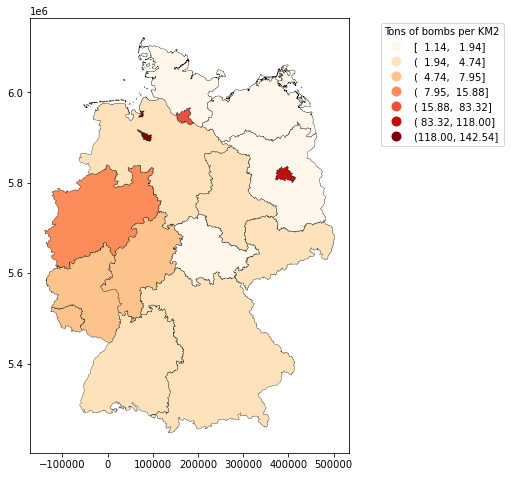

In [20]:
# Adjust figure size
fig, ax = plt.subplots(1, figsize=(10, 8))

# Adjust colors and add a legend
join.plot(ax=ax, column="TONS_PER_KM2", scheme="fisherjenks", k=7, cmap="OrRd", legend=True, edgecolor='black', linewidth=0.3)

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.5,1))
ax.get_legend().set_title("Tons of bombs per KM2")

1.1432470255390865

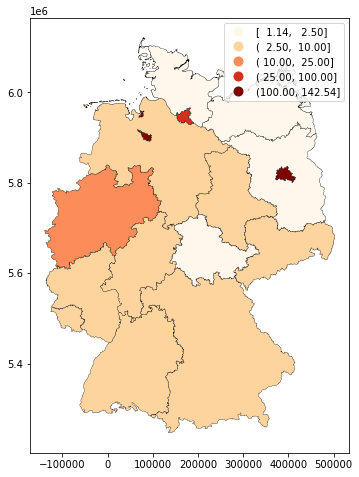

In [33]:
# Adjust figure size
fig, ax = plt.subplots(1, figsize=(10, 8))

# Adjust colors and add a legend
#join.plot(ax=ax, column="TONS_PER_KM2", cmap="OrRd", legend=True, edgecolor='black', linewidth=0.3)
#normalize = matplotlib.colors.Normalize(vmin=join["TONS_PER_KM2"].min(), vmax=join["TONS_PER_KM2"].max())
join.plot(ax=ax, column="TONS_PER_KM2", legend=True, edgecolor='black', cmap="OrRd", scheme='user_defined', classification_kwds={'bins':[ 2.5, 10, 25, 100, join["TONS_PER_KM2"].max()]}, linewidth=0.3)

join["TONS_PER_KM2"].min()

# Re-position the legend and set a title

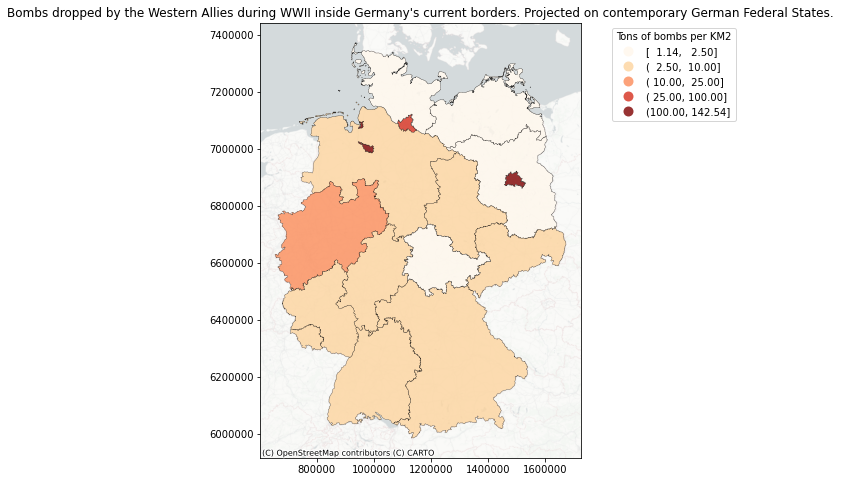

In [48]:
# Reproject to EPSG 3857 to be compatible with basemaps
join_wgs84 = join.to_crs(epsg=3857)

# Adjust figure size
fig, ax = plt.subplots(1, figsize=(10, 8))

# Plot the map and add a legend
join_wgs84.plot(ax=ax, column="TONS_PER_KM2",
                legend=True, edgecolor='black',
                cmap="OrRd", scheme='user_defined',
                # Apply user defined classification to the bombing map
                classification_kwds={'bins':[ 2.5, 10, 25, 100, join["TONS_PER_KM2"].max()]},
                linewidth=0.3, alpha=0.8)

# Adjust x axis label style
ax.ticklabel_format(style="plain")
# Set map title
plt.title("Bombs dropped by the Western Allies during WWII inside Germany's current borders. Projected on contemporary German Federal States.")

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.5,1))
ax.get_legend().set_title("Tons of bombs per KM2")

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)


dict_keys(['url', 'attribution', 'bounds', 'min_zoom', 'max_zoom', 'subdomains', 'name'])

In [51]:
import folium
from folium.plugins import HeatMap

In [75]:
m = folium.Map(location=[53.6, 10], tiles = 'CartoDB positron', zoom_start=6, control_scale=True)

ger_mercator = ger_bombs.to_crs(epsg=4326)
points = pd.DataFrame()
points["x"] = ger_mercator["geometry"].apply(lambda geom: geom.x)
points["y"] = ger_mercator["geometry"].apply(lambda geom: geom.y)
points["weight"]= ger_mercator["TOTAL_TONS"]
locations = list(zip(points["y"], points["x"], points["weight"]))
HeatMap(locations, radius = 20, max_val=500, max_zoom= 6).add_to(m)

In [76]:
m

In [27]:
m